# Introduction
This notebook walks through the fiducial registration process for just a single US/MPM image pair, and using the functions transferred to the multicscale-imaging package.

In [1]:
# Import basic moduless
from pathlib import Path
import numpy as np
import SimpleITK as sitk
%matplotlib notebook
import matplotlib.pyplot as plt
import tiffile as tif
import pickle
import os

In [2]:
# These modules all come from the multiscale-imaging package: https://github.com/uw-loci/multiscale
import multiscale.LINK_system.coordinate as coord
import multiscale.itk.transform as tran
import multiscale.itk.itk_plotting as iplt
import multiscale.itk.registration as reg
import multiscale.microscopy.ome as ome

In [3]:
fiducial_dir = Path(r'F:\Research\Fiducial paper analysis\Mouse images')

mpm_tile_path = Path(fiducial_dir, r'L22 fiducial MPM settings.ome.tif')
mpm_path = Path(fiducial_dir, r'L22 Fiducial MPM down 4x.tif')

us_path = Path(fiducial_dir, r'L22 fiducial Z16580_Run-1.tif')
us_pl_path = Path(fiducial_dir, 'L22 fiducial Z16580.pos')
us_param_path = Path(fiducial_dir, r'L22 fiducial Z16580_Run-1_Settings.mat')
us_height = 16580
dynamic_range = None

Open the images

In [4]:
mpm_image = coord.open_microscopy(mpm_path, mpm_tile_path, downsample_factor=4)

In [5]:
us_spacing = [36.001, 36.001, 36.001]
us_image = coord.open_us(us_path, us_pl_path, us_param_path, us_spacing, us_height, dynamic_range)

Acquire similar points between images

<IPython.core.display.Javascript object>


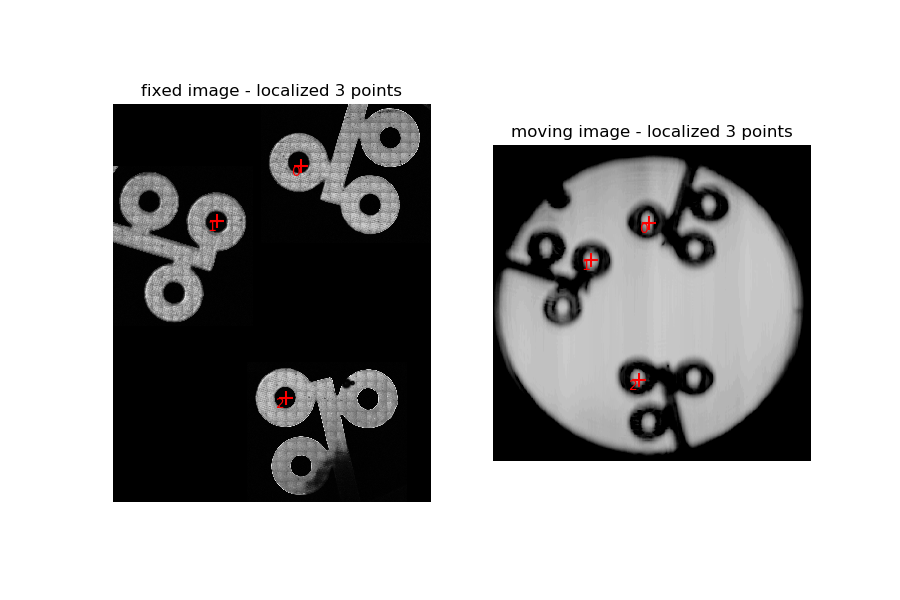

In [6]:
points = iplt.RegistrationPointDataAcquisition(mpm_image, us_image)

In [7]:
fixed_points, moving_points = points.get_points_flat()

Register the images

In [8]:
initial_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), fixed_points, moving_points)
final_transform, metric, stop = reg.register(mpm_image, us_image, initial_transform=initial_transform)
final_params = final_transform.GetParameters()

In [9]:
centroid = coord.calculate_centroid(us_image[:, :, 50:125], output_label_img=False)

Threshold used: 52.0


In [10]:
fiducial_bottom = np.mean(centroid)

z_translation = fiducial_bottom - (mpm_image.GetOrigin()[2] - 25)

In [11]:
coordinate_transform = np.array(final_params)
coordinate_transform[5] = z_translation
print('Final coordinate transform: {}'.format(coordinate_transform))

Final coordinate transform: [ 9.87467791e-04  9.41823069e-04 -2.16350608e-04 -3.53396733e+03
  5.08776321e+03  2.40739152e+04]


In [12]:
# Save the results
coordinate_path = Path(fiducial_dir, 'L22 Transform.txt')
with open(coordinate_path, 'wb') as fp:
    pickle.dump(coordinate_transform, fp)